# FDTD3D Plane-Wave Forward Propagation

This notebook runs a 3D FDTD simulation of a forward-propagating plane wave in free space and visualizes steady-state propagation.

In [21]:
# 1. Import Libraries and Configure JAX
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from wide_angle_propagation import RelativisticSolver3D, calculate_physics_params

# Configure JAX (64-bit for stability)
jax.config.update("jax_enable_x64", True)

## 2. Define Units and Physics Helpers

In [22]:
def wavelength_to_energy_ev(lam_angstrom):
    # Relativistic kinetic energy in eV
    lam = lam_angstrom * 1e-10
    h = 6.62607015e-34
    c = 299792458.0
    m = 9.1093837015e-31
    e = 1.602176634e-19
    p = h / lam
    E_total_J = np.sqrt((p*c)**2 + (m*c**2)**2)
    E_kin_J = E_total_J - (m*c**2)
    return E_kin_J / e

# Reference wavelength (Å)
wavelength_angstrom = 0.05
e_total, p_inf, e_sim = calculate_physics_params(wavelength_angstrom)
k0 = p_inf

print(p_inf, e_sim)
energy_ev = wavelength_to_energy_ev(wavelength_angstrom)

print(f"wavelength = {wavelength_angstrom} Å")
print(f"k0 (a.u.) = {k0:.6f}")
print(f"energy (eV) = {energy_ev:.2f}")

66.49836952842307 2211.016574969353
wavelength = 0.05 Å
k0 (a.u.) = 66.498370
energy (eV) = 56987.19


## 3. Create 3D Grid and PML Padding

In [23]:
# Grid (ROI)
nx, ny = 64, 64
roi_nz = 256

roi_xmin, roi_xmax = -1.0, 1.0
roi_ymin, roi_ymax = -1.0, 1.0
roi_zmin, roi_zmax = -1.0, 1.0

x = np.linspace(roi_xmin, roi_xmax, nx)
y = np.linspace(roi_ymin, roi_ymax, ny)
z = np.linspace(roi_zmin, roi_zmax, roi_nz)
dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1] - z[0]
extent_roi = [roi_xmin, roi_xmax, roi_ymin, roi_ymax, roi_zmin, roi_zmax]

# Extended grid for FDTD
pml_thickness = 0.2
source_buffer = 0.2
z_pad = pml_thickness + source_buffer
ext_zmin = roi_zmin - z_pad
ext_zmax = roi_zmax + z_pad
ext_nz = int(np.round((ext_zmax - ext_zmin) / dz))
z_ext = np.linspace(ext_zmin, ext_zmin + (ext_nz - 1) * dz, ext_nz)
ext_zmax = z_ext[-1]
extent_ext = [roi_xmin, roi_xmax, roi_ymin, roi_ymax, ext_zmin, ext_zmax]

print("Grid Summary:")
print(f"  ROI:  {nx}x{ny}x{roi_nz}")
print(f"  FDTD: {nx}x{ny}x{ext_nz}")
print(f"  Steps: dx={dx:.4f}, dz={dz:.4f}")

Grid Summary:
  ROI:  64x64x256
  FDTD: 64x64x357
  Steps: dx=0.0317, dz=0.0078


## 4. Build Homogeneous Medium Potential (Vacuum)

In [24]:
# Vacuum potential (eV) on extended grid
v_fdtd_ev = np.zeros((ext_nz, ny, nx), dtype=np.float64)

## 5. Initialize Plane-Wave Source

In [25]:
# Source plane index (near low-z side, after PML)
dist_src = pml_thickness + source_buffer * 0.5
k_source = int(dist_src / dz)

# Ensure source is outside PML by a few cells
pml_cells = int(np.ceil(pml_thickness / dz))
min_source = pml_cells + 2
if k_source < min_source:
    k_source = min_source
k_source = max(1, min(k_source, ext_nz - 2))

print(f"dz={dz:.4f} Å, pml_cells={pml_cells}, k_source={k_source}")
print(f"k_source z ~ {ext_zmin + k_source*dz:.3f} Å")

dz=0.0078 Å, pml_cells=26, k_source=38
k_source z ~ -1.102 Å


## 6. Run FDTD3D Propagation

In [26]:
solver = RelativisticSolver3D()

# Run full propagation but save only the final frame
total_steps = 20000
n_frames = 20
steps_per_frame = total_steps // n_frames  # run all steps in a single frame
snapshot_count = 20
print(f"Total steps: {total_steps} (saving {n_frames} frames)")

fdtd_res = solver.run(
    v_fdtd_ev,
    wavelength_angstrom=wavelength_angstrom,
    extent=extent_ext,
    n_frames=n_frames,
    steps_per_frame=steps_per_frame,
    snapshot_count=snapshot_count,
    pml_thick=pml_thickness,
    k_source=k_source,
    use_angstrom_units=True,
)

if not fdtd_res:
    raise RuntimeError("FDTD3D run failed")

snapshots = fdtd_res["snapshots"]
E_sim = fdtd_res["E_sim"]
dt = fdtd_res["dt"]
print(f"Snapshots: {len(snapshots)}, E_sim={E_sim:.6f}, dt={dt:.2e}")

Total steps: 20000 (saving 20 frames)
Running 3D: fdtd_3d_bin 20 1000 20 -0.05
Loaded 20 snapshots.
Snapshots: 20, E_sim=54128.367188, dt=2.00e-06


## 7. Collect Steady-State Snapshots

In [27]:
start_avg = int(0.6 * len(snapshots))
psi_accum = np.zeros((ext_nz, ny, nx), dtype=np.complex128)
count = 0

for t, phi, psi in snapshots[start_avg:]:
    phasor = np.exp(1j * E_sim * t)
    field3d = (phi + 1j * psi) * phasor
    psi_accum += field3d
    count += 1

psi_ss = psi_accum / max(1, count)
print(f"Averaged {count} snapshots")

Averaged 8 snapshots


In [28]:
# Phase advance per saved frame (check for near-2π aliasing)
phase_per_frame = E_sim * steps_per_frame * dt
two_pi = 2 * np.pi
print(f"Phase advance per frame: {phase_per_frame:.4f} rad")
print(f"Phase advance / 2π = {phase_per_frame / two_pi:.4f}")
if np.isclose((phase_per_frame / two_pi) % 1.0, 0.0, atol=0.05):
    print("Warning: snapshots may be phase-aliased (near integer cycles). Try changing steps_per_frame.")

Phase advance per frame: 108.2567 rad
Phase advance / 2π = 17.2296


## 8. Visualize 3D Slices and X–Z Intensity

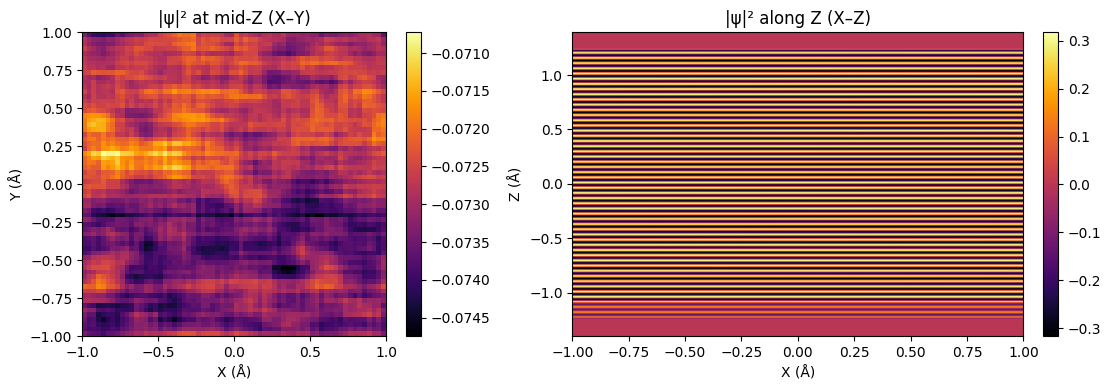

In [29]:
k_mid = ext_nz // 2
central_y = ny // 2

psi_xy = np.real(psi_ss[k_mid, :, :])
psi_xz = np.real(psi_ss[:, central_y, :])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im0 = axes[0].imshow(psi_xy, extent=[x[0], x[-1], y[0], y[-1]], origin='lower', cmap='inferno')
axes[0].set_title("|ψ|² at mid-Z (X–Y)")
axes[0].set_xlabel("X (Å)")
axes[0].set_ylabel("Y (Å)")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(psi_xz, extent=[x[0], x[-1], z_ext[0], z_ext[-1]], origin='lower', aspect='auto', cmap='inferno')
axes[1].set_title("|ψ|² along Z (X–Z)")
axes[1].set_xlabel("X (Å)")
axes[1].set_ylabel("Z (Å)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 9. Animate X–Z Cross-Section Over Time

In [30]:
import matplotlib.animation as animation

# Use a subset of snapshots for speed
stride = max(1, len(snapshots) // 50)
frames = snapshots[::stride]
central_y = ny // 2

fig, ax = plt.subplots(figsize=(5, 4))
t0, phi0, psi0 = frames[0]
field0 = (phi0 + 1j * psi0)
img0 = np.real(field0[:, central_y, :])
im = ax.imshow(img0, extent=[x[0], x[-1], z_ext[0], z_ext[-1]], origin='upper', aspect='auto')
ax.set_xlabel("X (Å)")
ax.set_ylabel("Z (Å)")
ax.set_title("X–Z Real(ψ) (central Y)")
cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

def update(frame):
    t, phi, psi = frame
    field = (phi + 1j * psi)
    img = np.abs(field[:, central_y, :])**2
    im.set_array(img)
    ax.set_title(f"X–Z |ψ| (t={t:.3e})")
    return (im,)

ani = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True)

# Save as GIF (no ffmpeg dependency)
out_path = "fdtd3d_plane_wave_xz_real.gif"
ani.save(out_path, writer=animation.PillowWriter(fps=10))
plt.close(fig)
print(f"Saved animation: {out_path}")

Saved animation: fdtd3d_plane_wave_xz_real.gif
